# Machine Learning with K-Nearest Neighbor Regression and Classification Problem

Machine learning has two major brances: regression and classification. This notebook I will dig into one of the classics methodologies: K-Nearest Neighbor and I am going to build classifier and regressor on Housing Price Data. 

The following notebook I cover:
- $\textbf{Environment Initiation}$.
- $\textbf{Data Collection}$.
- $\textbf{Feature Transformation}$.
- $\textbf{K-Nearest Neighbor Regression}$.
- $\textbf{Cross Validation}$.
- $\textbf{Binary Classification}$.
- $\textbf{Multi-Class Classification}$.

Source: I use [Chapter 6](https://github.com/PacktPublishing/Hands-On-Machine-Learning-for-Algorithmic-Trading/blob/master/Chapter06/01_machine_learning_workflow.ipynb) in the book **Hands-on Machine Learning for Algorithmic Trading**.

## Environment Initiation

Let us set up global environment for this python notebook.

In [19]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, validation_curve, learning_curve, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Data Collection

Let me download data from the link below and upload data from **data** folder in this repository.

Data source: [Kaggle Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data#)

In [3]:
house_sales = pd.read_csv('../data/kc_house_data.csv')
house_sales.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [4]:
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Feature Transformation

Feature Transformation

### Asset Prices: Long Tails

Asset prices often times have distribution with long tails (fat tails). Let us use *sns.distplot()* to take a look at the distribution, e.g. the density curve.

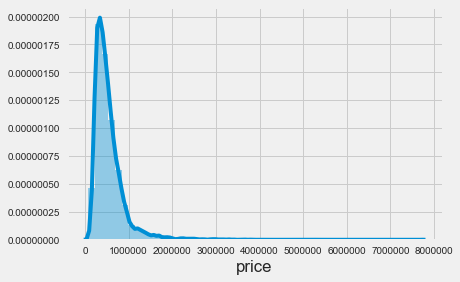

In [5]:
sns.distplot(house_sales.price)

### Log-Transformation

For fat-tailed distribution, one common practice is to use log-transformation

In [6]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

### Mutual Information

Mutual information can capture any kind of dependency between variables. 

In [7]:
mi_reg = pd.Series(mutual_info_regression(X_all, y), index=X_all.columns).sort_values(ascending=True)
mi_reg

yr_renovated     0.010812
condition        0.012800
waterfront       0.014371
view             0.058245
sqft_lot         0.062847
sqft_basement    0.069146
yr_built         0.076924
bedrooms         0.077198
floors           0.079066
sqft_lot15       0.084868
bathrooms        0.202861
sqft_above       0.262362
sqft_living15    0.272040
grade            0.343484
sqft_living      0.348435
dtype: float64

Let us update our explanatory variables based on what we learned from mutual information which is saved in *mi_reg*.

In [8]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

### Bivariate Scatter Plots

Let us check out association between dependent variable $y$ and each of the covariates in $X$ using Bivariate Scatter Plots by *.pairplot()* function

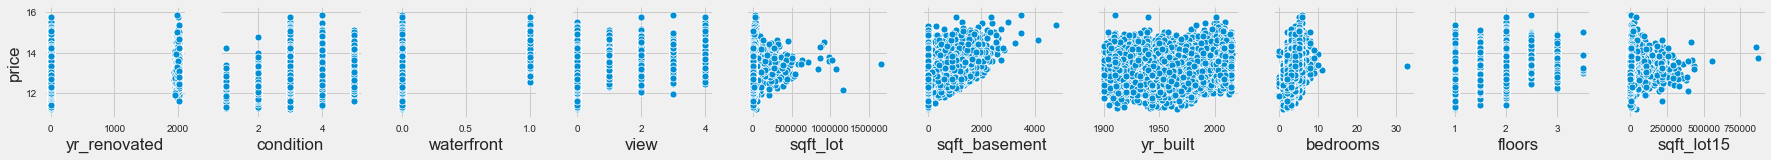

In [9]:
sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)

### Explore Correlations

Let us check out correlations

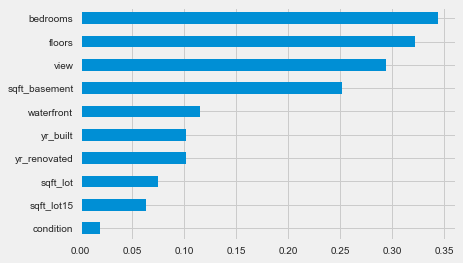

In [10]:
correl = (X.apply(lambda x: spearmanr(x, y)).apply(pd.Series, index=['r', 'pval']))
correl.r.sort_values().plot.barh()

## K-Nearest Neighbor Regression

In-sample performance with default setting: KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale.

In [11]:
X_scaled = scale(X)

In [12]:
KNN_Reg = KNeighborsRegressor()
KNN_Reg.fit(X=X_scaled, y=y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [13]:
y_pred_train = KNN_Reg.predict(X_scaled)

In [14]:
RMSE_train = (np.mean((y_pred_train - y)**2))**(0.5)
print(f'Training Set RMSE = {RMSE_train}')

Training Set RMSE = 0.32860873906087606


Regression error metrics:

In [15]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

Computing the prediction error

In [22]:
error = (y - y_pred_train).rename('Prediction Errors')

In [23]:
scores = dict(
    rmse = np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred_train)),
    rmsle = np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred_train)),
    mean_ae = mean_absolute_error(y_true=y, y_pred=y_pred_train),
    median = median_absolute_error(y_true=y, y_pred=y_pred_train),
    r2score = explained_variance_score(y_true=y, y_pred=y_pred_train)
)

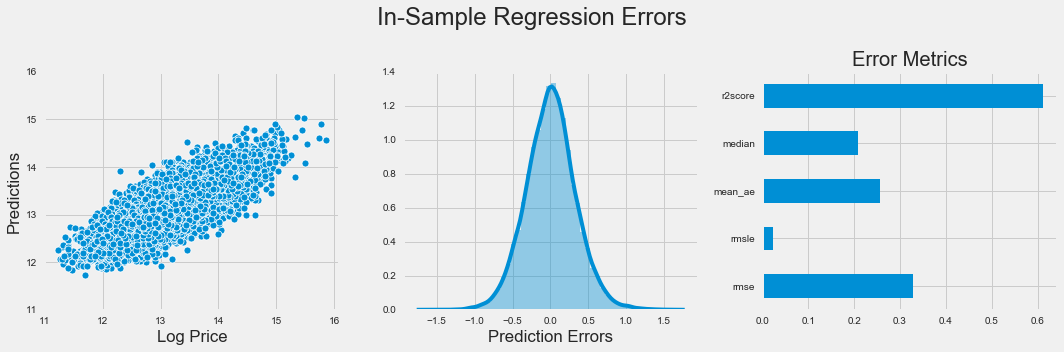

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred_train, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8)

The above code tells us the performance we have on in-sample training set. In practice, we should also examine the performance on out-of-sample test set.

## Cross Validation

Let us conduct manual parameters tuning. 

In [25]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))
rmse_score = make_scorer(rmse)

In [31]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])
    cv_rmse[n] = cross_val_score(
        pipe, 
        X=X, 
        y=y,
        scoring=rmse_score,
        cv=5)

In [32]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ['n', 'fold', 'RMSE']

Text(0.5,1,'Cross-Validation Results KNN | Best N: 20 | Best RMSE: 0.39')

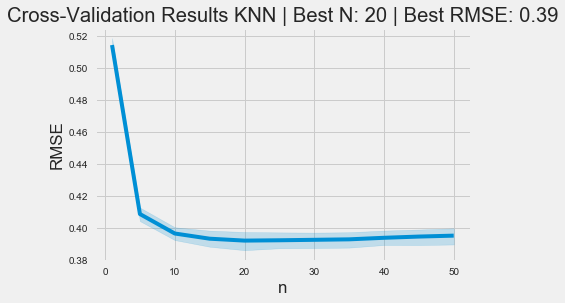

In [34]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}')

Let us visualize actual dependent variable $y$ and predicted variable $\hat{y}$ using scatter plot.

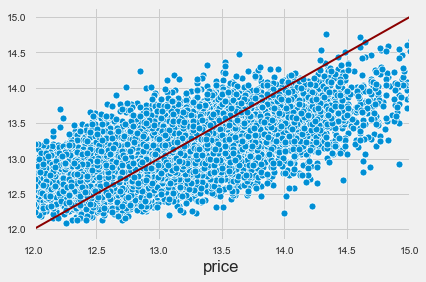

In [36]:
pipe = Pipeline([('Scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)
ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred')

With the results of cross validation trained above with in-sample training set, let us check out the errors.

In [37]:
error = (y - y_pred).rename('Prediction Errors')
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

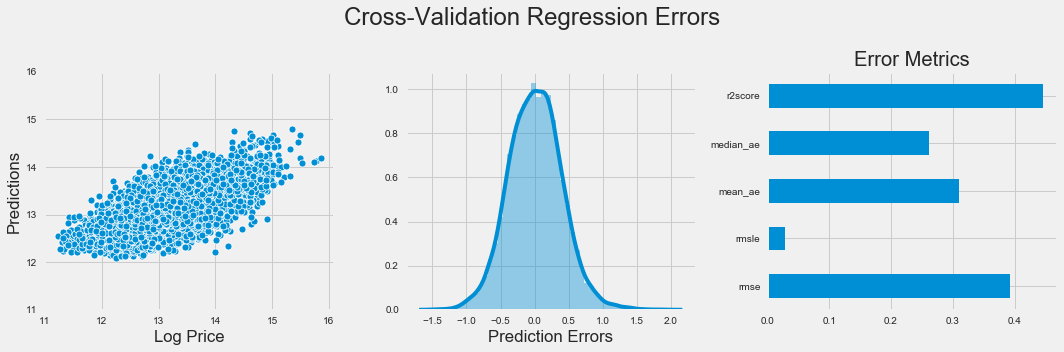

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8)

We can also conduct a grid search cross validation with *Pipeline()*

In [41]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])
n_folds = 5
n_neighbors = tuple(range(5, 101, 5))
param_grid = {'knn__n_neighbors': n_neighbors}
estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score)#, n_jobs=-1
estimator.fit(X=X, y=y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             iid='

Let us extract the result.

In [42]:
cv_results = estimator.cv_results_
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                          index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

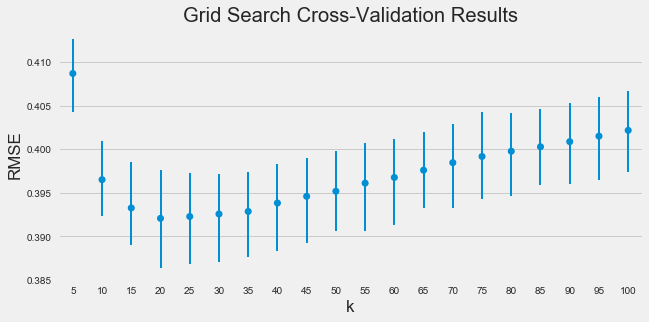

In [44]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Grid Search Cross-Validation Results')
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)

## Training and Validation Curves

Let examine the learning curves for training and validation using *yellowbricks*.

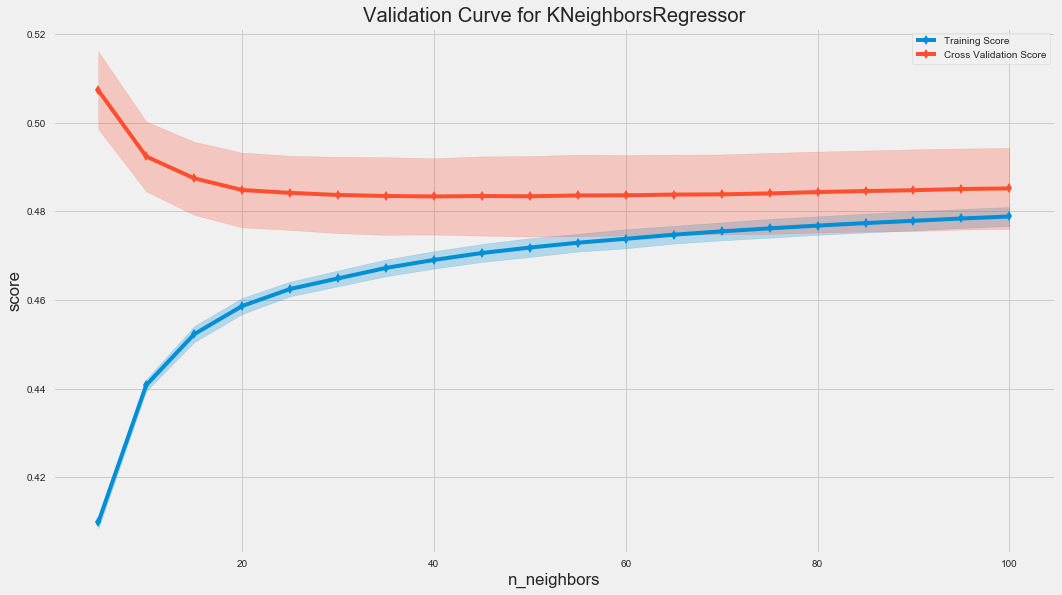

In [46]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
fig.tight_layout()

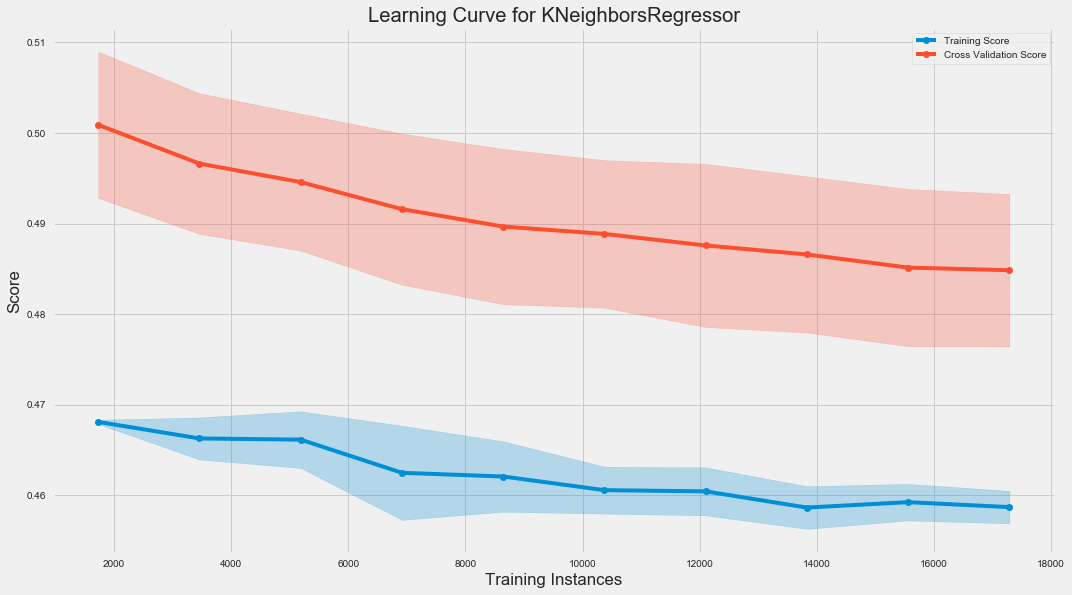

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k),
                     train_sizes=np.arange(.1, 1.01, .1),
                     scoring=rmse_score,
                     cv=5,
                     ax=ax)
l_curve.fit(X, y)
l_curve.poof()
fig.tight_layout()

## Binary Classification

Instead of a regression problem, we can also conduct a classification problem.

In [50]:
y_binary = (y > y.mean()).astype(int)
y_binary

0        0
1        1
2        0
3        1
4        1
        ..
21608    0
21609    0
21610    0
21611    0
21612    0
Name: price, Length: 21613, dtype: int32

In [51]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [52]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': n_neighbors}
estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring)
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [53]:
best_k = estimator.best_params_['knn__n_neighbors']

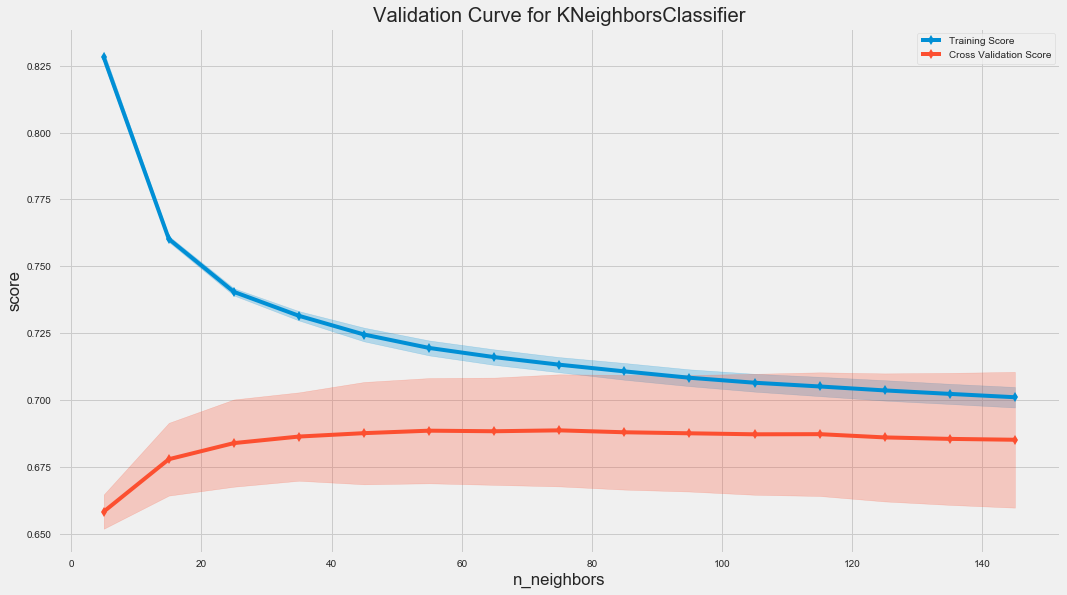

In [55]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
fig.tight_layout()

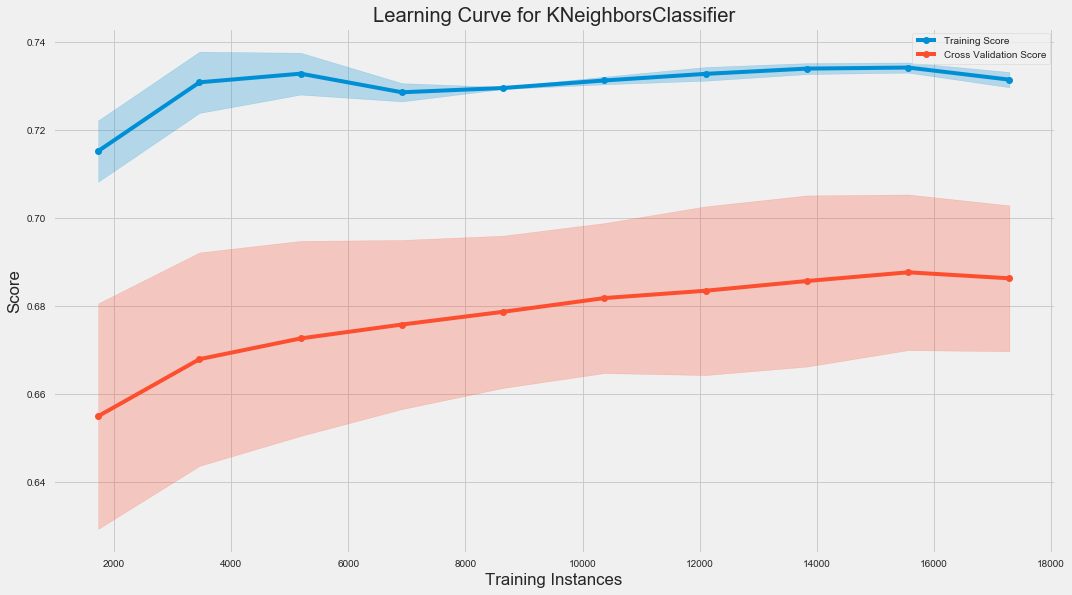

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
fig.tight_layout();

What are the classification metrics

In [59]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             auc,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_similarity_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             precision_recall_fscore_support,
                             average_precision_score,
                             precision_recall_curve,
                             precision_score,
                             recall_score)

We have just imported the following metrics:

| Name | API |
|------|------|
| Area Under the Receiver Operating Characteristic Curve (ROC AUC) | roc_auc_score(y_true, y_score[, …]) |
| Receiver operating characteristic (ROC) | roc_curve(y_true, y_score[, …]) |
| Average precision (AP) | average_precision_score(y_true, y_score) |
| Precision-recall pairs | precision_recall_curve(y_true, …) |
| Precision, recall, F-measure and support | precision_recall_fscore_support(…) |
| F1 Score | f1_score(y_true, y_pred[, labels, …]) |
| F-beta Score | fbeta_score(y_true, y_pred, beta[, …]) |
| Precision | precision_score(y_true, y_pred[, …] |
| Recall | recall_score(y_true, y_pred[, …]) |
| Main classification metrics | classification_report(y_true, y_pred) |
| confusion matrix | confusion_matrix(y_true, y_pred[, …]) |
| Accuracy classification score | accuracy_score(y_true, y_pred) |
| Zero-one classification loss | zero_one_loss(y_true, y_pred[, …]) |
| Average Hamming loss | hamming_loss(y_true, y_pred[, …]) |
| Brier score | brier_score_loss(y_true, y_prob[, …]) |
| Cohen’s kappa | cohen_kappa_score(y1, y2[, labels, …]) |
| Average hinge loss | hinge_loss(y_true, pred_decision[, …]) |
| Jaccard similarity coefficient | jaccard_similarity_score(y_true, y_pred) |
| Log loss, aka logistic loss or cross-entropy loss | log_loss(y_true, y_pred[, eps, …]) |
| Matthews correlation coefficient (MCC) | matthews_corrcoef(y_true, y_pred[, …]) |


In [61]:
y_score = cross_val_predict(KNeighborsClassifier(best_k),
                            X=X,
                            y=y_binary,
                            cv=5,
                            method='predict_proba')[:, 1]

Let us use the probabilities.

In [62]:
pred_scores = dict(y_true=y_binary, y_score=y_score)

Let us use AUC.

In [63]:
roc_auc_score(**pred_scores)

0.6864475606107686

In [64]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

Let us also compute precision and recall.

In [65]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

We can also use F1 score.

In [66]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

Let us visualize the performance.

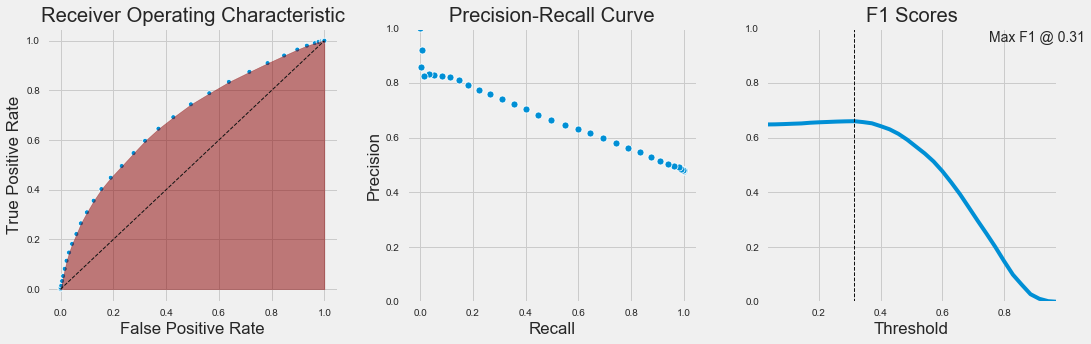

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

"""Let me plot three graphs and I will code them one by one."""
# first one
ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')

# second one
sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')

# third one
f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(text=f'Max F1 @ {best_threshold:.2f}', x=.75, y=.95, s=5)
fig.tight_layout();

In [68]:
print('Average Precision:', average_precision_score(y_true=y_binary, y_score=y_score))

Average Precision: 0.6612589621754505


In [69]:
print('Bierer Score;', brier_score_loss(y_true=y_binary, y_prob=y_score))

Bierer Score; 0.22332515294555336


We can also use predictions after threshold.

In [70]:
y_pred = y_score > best_threshold
scores = dict(y_true=y_binary, y_pred=y_pred)

In [71]:
print('F-beta score:', fbeta_score(**scores, beta=1))

F-beta score: 0.6597622960217068


In [72]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.70      0.36      0.48     11266
           1       0.55      0.83      0.66     10347

    accuracy                           0.59     21613
   macro avg       0.62      0.60      0.57     21613
weighted avg       0.63      0.59      0.57     21613



In [75]:
print('Confusion matrix:')
print(confusion_matrix(**scores))
print('Accuracy is:', accuracy_score(**scores))

Confusion matrix:
[[4078 7188]
 [1715 8632]]
Accuracy is: 0.5880719937074909


In [76]:
print('Zero-one Loss is:', zero_one_loss(**scores))

Zero-one Loss is: 0.41192800629250914


In [77]:
print('Hamming Loss (fractions of labels that are incorrectly predicted):', hamming_loss(**scores))

Hamming Loss (fractions of labels that are incorrectly predicted): 0.41192800629250914


In [79]:
print('Cohen Kappa (Score that expresses the level of agreement between two annotators on a classification problem):', 
      cohen_kappa_score(y1=y_binary, y2=y_pred))

Cohen Kappa (Score that expresses the level of agreement between two annotators on a classification problem): 0.19208162349370017


In [80]:
print('Hinge Loss:', hinge_loss(y_true=y_binary, pred_decision=y_pred))

Hinge Loss: 0.9331883588580947


In [81]:
print('Jaccard Similarity:', jaccard_similarity_score(**scores))

Jaccard Similarity: 0.5880719937074909


In [82]:
print('Cross Entropy (Log Loss):', log_loss(**scores))

Cross Entropy (Log Loss): 14.227755228344888


In [83]:
print('Matthews Correlation Coefficient:', matthews_corrcoef(**scores))

Matthews Correlation Coefficient: 0.22130573096805964


## Multi-Class Classification

We can cut $y$ into more than two classes and conduct multi-class classification.

In [85]:
y_multi = pd.qcut(y, q=3, labels=[0, 1, 2])
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [86]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': n_neighbors}
estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds)
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [87]:
y_pred = cross_val_predict(estimator.best_estimator_,
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           method='predict')
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.57      0.66      0.61      7226
           1       0.46      0.39      0.42      7223
           2       0.64      0.65      0.65      7164

    accuracy                           0.56     21613
   macro avg       0.56      0.57      0.56     21613
weighted avg       0.56      0.56      0.56     21613

